# Constrained generation to guarantee syntactic correctness

```{note}
If we want to generate output that is structured in a specific way, we can use various techniques to 

- make the extraction more efficient (but automatically adding the "obvious" tokens)
- make the generation guaranteed to be syntactically correct
- make the generation sometimes more semantically correct, too 
```

To enable constrained decoding, we will use one of the most popular packages for this task [`instructor`](https://jxnl.github.io/instructor/).
It is built on [`pydantic`]() and can leverage function calling and JSON-mode of the OpenAI API as well as other constrained sampling approaches.

In [2]:
from pydantic import BaseModel, Field
from typing import List, Optional, Literal
import erdantic as erd
import instructor
from IPython.display import SVG
from openai import OpenAI

import llmstructdata

## Defining a data schema

For most constrained generation tasks, we need to define a data schema in a programmatic way.
The most common way to do so is to use `pydantic` data classes.
Here is an example of a simple data schema for a recipe:

```python
from pydantic import BaseModel

class Recipe(BaseModel):
    title: str
    ingredients: List[str]
    instructions: List[str]
```

This schema can also be extended to include descriptions of different fields or to only allow certain values for specific fields. For example, we could add a field for the number of servings and only allow positive integers.

```python
from pydantic import BaseModel, Field
from typing import Literal, List

class Recipe(BaseModel):
    title: str
    ingredients: List[str]
    instructions: List[str]
    servings: int = Field(..., gt=0, description="The number of servings for this recipe")
    rating: Literal["easy", "medium", "hard"] = Field("easy", description="The difficulty level of this recipe")
```

If we want to extract copolymerization reactions a data schema could look like the following.

We can now use `instructor` to "patch" the OpenAI API client to ensure that our output fulfils the schema.

In [3]:
client = instructor.patch(OpenAI(), mode=instructor.Mode.MD_JSON)


class Monomer(BaseModel):
    name: str = Field(..., title="Name", description="Name of the monomer.")
    reactivity_constant: Optional[float] = Field(
        None,
        title="Reactivity constant",
        description="Reactivity constant of the monomer. r1 for monomer 1 and r2 for monomer 2. Must be greater or equal 0.",
        ge=0,
    )
    reactivity_constant_error: Optional[float] = Field(
        None,
        title="Reactivity constant error",
        description="Error in the reactivity constant. Often indicated with +/-. Must be greater or equal 0",
        ge=0,
    )
    q_parameter: Optional[float] = Field(
        None,
        title="Q parameter",
        description="Q parameter of the monomer. Q1 for monomer 1 and Q2 for monomer 2. Must be greater or equal 0",
        ge=0,
    )
    e_parameter: Optional[float] = Field(
        None,
        title="e parameter",
        description="e parameter of the monomer. e1 for monomer 1 and e2 for monomer 2.",
    )


class CopolymerizationReaction(BaseModel):
    temperature: Optional[float] = Field(
        ...,
        title="Temperature",
        description="Temperature at which the reaction is carried out",
    )
    temperature_unit: Optional[Literal["C", "K"]] = Field(
        ..., title="Temperature unit", description="Unit of temperature"
    )
    solvent: Optional[str] = Field(
        None,
        title="Solvent",
        description="Solvent used in the reaction. If bulk polymerization was performed, this field should be left empty",
    )
    initiator: Optional[str] = Field(
        None, title="Initiator", description="Initiator used in the reaction"
    )
    monomers: Optional[List[Monomer]] = Field(
        ...,
        title="Monomers",
        description="Monomers used in the reaction. Ensure that the reactivity ratios are not confused with other numbers (such as Q and e). The two monomers MUST be used in the same reaction and mentioned in the same context.",
        min_items=2,
        max_items=2,
    )
    polymerization_type: Optional[str] = Field(
        ...,
        title="Polymerization type",
        description="Type of polymerization (e.g., bulk, solution, suspension, emulsion)",
    )
    determination_method: Optional[str] = Field(
        ...,
        title="Determination method",
        description="Method used to determine the reactivity ratios (e.g. Kelen Tudor, Fineman-Ross, Mayo-Lewis).",
    )

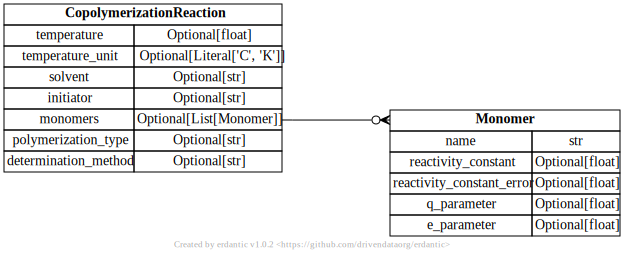

In [4]:
diagram = erd.create(CopolymerizationReaction)
diagram.draw("diagram.svg")
SVG("diagram.svg")

In this case, we will use PDF files in the form as images as input for the model. To perform this conversion, we import some utilities.

In [5]:
from pdf2image import convert_from_path
from utils import process_image, get_prompt_vision_model

The code below only converts each page of the PDF into an image and then generates dictionary objects in a format that can be used by the OpenAI API.

In [6]:
filepath = "paper01.pdf"
pdf_images = convert_from_path(filepath)

images_base64 = [
    process_image(image, 2048, "images", filepath, j)[0]
    for j, image in enumerate(pdf_images)
]
images = get_prompt_vision_model(images_base64=images_base64)

Armed with the images, we can now use the OpenAI API to extract the text from the images.
For this, we just call the API with our prompts and the images.

In [7]:
completion = client.chat.completions.create(
    model="gpt-4-turbo",
    response_model=List[CopolymerizationReaction],
    max_retries=2,
    messages=[
        {
            "role": "system",
            "content": """You are a scientific assistant, extracting accurate information about co-polymerization reactions from scientific papers.
Do not use data that was reproduced from other sources.
If you confuse the reactivity ratios with other numbers, you will be penalized.
Monomer names might be quite similar, if you confuse them, you will be penalized.
NEVER combine data from different reactions, otherwise you will be penalized.
If you are unsure, return no data. Quality is more important than quantity.
""",
        },
        {
            "role": "user",
            "content": """Extract the data from the paper into the provided data schema. We want an iterable of reaction objects and each reaction will be its own object. You can find each page of the paper as an image below.
The relationship between monomers and parameters is typically indicated by subscripts that can be a number or an abbreviation of the monomer.
Never return data that you are not absolutely sure about! You will be penalized for incorrect data.""",
        },
        {"role": "user", "content": [*images]},
    ],
    temperature=0,
)

In [8]:
completion

[CopolymerizationReaction(temperature=60.0, temperature_unit='C', solvent='carbon tetrachloride', initiator='AIBN', monomers=[Monomer(name='methacrylic acid', reactivity_constant=0.54, reactivity_constant_error=0.01, q_parameter=None, e_parameter=None), Monomer(name='styrene', reactivity_constant=0.06, reactivity_constant_error=0.03, q_parameter=None, e_parameter=None)], polymerization_type='solution', determination_method='Kelen-Tudos'),
 CopolymerizationReaction(temperature=60.0, temperature_unit='C', solvent='chloroform', initiator='AIBN', monomers=[Monomer(name='methacrylic acid', reactivity_constant=0.51, reactivity_constant_error=0.01, q_parameter=None, e_parameter=None), Monomer(name='styrene', reactivity_constant=0.08, reactivity_constant_error=0.03, q_parameter=None, e_parameter=None)], polymerization_type='solution', determination_method='Kelen-Tudos'),
 CopolymerizationReaction(temperature=60.0, temperature_unit='C', solvent='acetone', initiator='AIBN', monomers=[Monomer(nam